<a href="https://colab.research.google.com/github/jieunjeon/Data-Science-Fundamental/blob/master/Exploration/%5BE_03%5D_Face_Detection_Whisker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's Build a Camera App with Whiscker!
## Goal of this project
- Add a cute whiscker on the original selfie image.
- Analyze how the angle / brighteness / perspective can affect the model.
- Learn concepts of: video processing, detection, keypoint estimation, tracking, camera perspective
- Build a Camera app that is robust at distance changes and angles

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Prepare Selfie
I am going to use my fav K-pop idol, Jeong Se-woon's selfie.
Image ref: https://twitter.com/jeongsewoon_twt/status/1101775665311834113?lang=bg

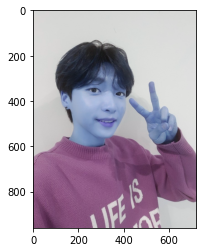

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

my_image_path = '/content/drive/MyDrive/aiffel/EXP_3_data/image.png';
img_bgr = cv2.imread(my_image_path)    # Read image with OpenCV
img_bgr = cv2.resize(img_bgr, (720, 960))    # Resize to 720 X 960
img_show = img_bgr.copy()      # store a copy of the image
plt.imshow(img_bgr)
plt.show()

The image libraries such as matplotlib and dlib use **image channels in RGB **(red, green, blue) order, so I will convert the RGB color for ths image

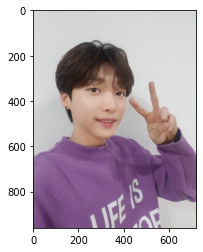

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# Face Detection and Find the LandMark
Let's find the bounding box positions of the face and the positions of  landmark.

## Face Detection with dlib

In [ ]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   # initialize detector

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # image, num of img pyramid

rectangles[[(170, 241) (491, 562)]]


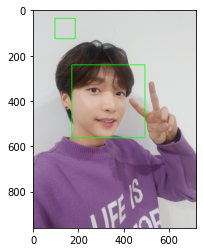

In [ ]:
print(dlib_rects)   # coordinates of the face found

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Face LandMark Localization
Lets find the bounding box and predict the keypoint inside the box.   
I will use `dlib` provided model. It is a pretrained model with the ibug 300-W dataset. The learning algorithm used an ensemble model of the regression tree.     

Refer to the paper One Millisecond Face Alignment with an Ensemble of Regression Trees published in CVPR (Computer Vision and Pattern Recognition) in 2014. It's okay if you don't understand algorithms today.   
Ref to the article: https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf


In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 /content/drive/MyDrive/aiffel/EXP_3_data

!bzip2 -d /content/drive/MyDrive/aiffel/EXP_3_data/shape_predictor_68_face_landmarks.dat.bz2

In [ ]:
model_path = '/content/drive/MyDrive/aiffel/EXP_3_data/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

`landmark_predictor` takes an `RGB image` and `dlib.rectangle` as input and returns `dlib.full_object_detection` .

In [ ]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


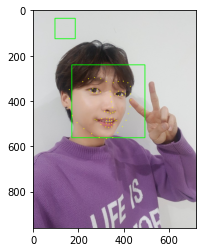

In [ ]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.clf()
plt.imshow(img_show_rgb)
plt.show()
plt.close()

Now I can see the white dots are all around the points, eyebrow, eyes, noes, mouth, and chin.   


# Prepare Whisckers

Let's prepare the whisckers image and put it on.   

1. The position of the sticker   
$x = x_{nose}$   
$y = y_{nose} + {y_{mouth} - y_{nose} \over 2}$   
   
2. The size of the sticker   
$2 * width = height = {width_{bbox} \over 2}$

Let's check the coordinates first.
I set y to use the y coordinates of noes and mouth, and calculate a median points btn the nose and the mouth.

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = int(landmark[30][1] + (landmark[62][1] - landmark[30][1] )//2) # center index : 62
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(348, 428)
(x,y) : (348,457)
(w,h) : (322,322)


The center coordinates of the whisckers is `(348, 428)`.   
Then let's read the whisckers image and resize it based on the above calculated size

In [ ]:
sticker_path = '/content/drive/MyDrive/aiffel/EXP_3_data/whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(322, 322, 3)


Edit the (x,y) coordinates to add this crown sticker image to the original image.  
 Mind that the start point is the top-left.

In [ ]:
refined_x = x - w // 2  # left
refined_y = y - h // 2       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (187,296)


In [ ]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

Here I edited the code to compare the `img_sticker` with 255 to remove the whitespaces.

In [ ]:
img_show = img_bgr.copy()

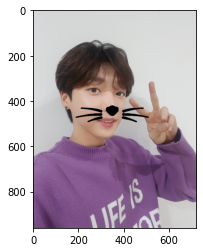

In [ ]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

How cute he is!!!! S2

Next, I will try how this model works for a face image with side face.

# Side Face Detection and LandMark

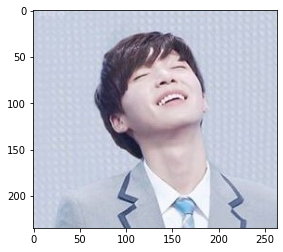

In [ ]:
my_image_path = '/content/drive/MyDrive/aiffel/EXP_3_data/image6.png';
img_bgr2 = cv2.imread(my_image_path)    # Read image with OpenCV
img_bgr2 = cv2.resize(img_bgr2, (263, 235))    # Resize to 640x360의 
img_show_side_copy = img_bgr2.copy()      # store a copy of the image
plt.imshow(img_bgr2)

img_rgb = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [ ]:
my_image_path = '/content/drive/MyDrive/aiffel/EXP_3_data/image6.png';
img_bgr3 = cv2.imread(my_image_path)    # Read image with OpenCV
img_bgr3 = cv2.resize(img_bgr3, (263, 235))    # Resize to 640x360의 
img_backup = img_bgr3.copy()

rectangles[[(96, 36) (185, 126)]]


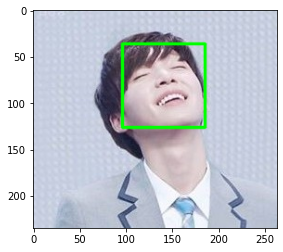

In [ ]:
detector_hog = dlib.get_frontal_face_detector()   # initialize detector
img_rgb = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # image, num of img pyramid

print(dlib_rects)   # coordinates of the face found

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_side_copy, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_side_copy_rgb =  cv2.cvtColor(img_show_side_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_side_copy_rgb)
plt.show()

Let's see the LandMark result on this side face!

In [ ]:
model_path = '/content/drive/MyDrive/aiffel/EXP_3_data/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [ ]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


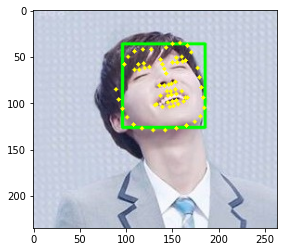

In [ ]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show_side_copy, point, 2, (0, 255, 255), -1) # yellow

img_show_side_copy_rgb = cv2.cvtColor(img_show_side_copy, cv2.COLOR_BGR2RGB)
plt.clf()
plt.imshow(img_show_side_copy_rgb)
plt.show()
plt.close()

I will use the same positioni calculation for the sticker

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = int(landmark[30][1] + (landmark[62][1] - landmark[30][1] )//2) # mouth center index : 62
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(143, 68)
(x,y) : (143,79)
(w,h) : (90,90)


In [ ]:
sticker_path = '/content/drive/MyDrive/aiffel/EXP_3_data/whiskers.png'
side_img_sticker = cv2.imread(sticker_path)
side_img_sticker = cv2.resize(side_img_sticker, (w,h))
print (side_img_sticker.shape)

(10, 55, 3)


In [ ]:
refined_x = x - w // 2  # left
refined_y = y - h // 2       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (98,34)


In [ ]:
sticker_area = img_show_side_copy[refined_y:refined_y+side_img_sticker.shape[0], refined_x:refined_x+side_img_sticker.shape[1]]
img_show_side_copy[refined_y:refined_y+side_img_sticker.shape[0], refined_x:refined_x+side_img_sticker.shape[1]] = \
    np.where(side_img_sticker==255, sticker_area, side_img_sticker).astype(np.uint8)

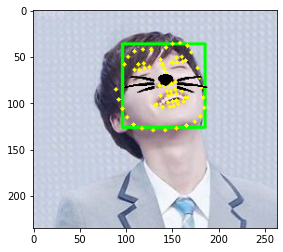

In [ ]:
plt.imshow(cv2.cvtColor(img_show_side_copy, cv2.COLOR_BGR2RGB))
plt.show()

Ok, I got the whiskers on his side face!!   
But I found something weird, that the whiskers is too algned well. his face is a little tilted, but the whiskers is not.   
Let's try to **algin the whiskers** correctly with his **face angle**.

To rotate the whiskers, I will use this method `cv2.getRotationMatrix2D`.    
I need to find center, angle, and scale parameter to use this. I can put center as the coordinates of the noes, and I can put scale 1. But to find the angle, I will use this arctangent with pi to get the angle between the coordinates of the two eyes.   
I got the indices of the eyes from this table. This coordinates are based on the model that I am using. (link attached above)    
I will use the index 36 for the left-most eye index, and 45 for the right-most eye index.

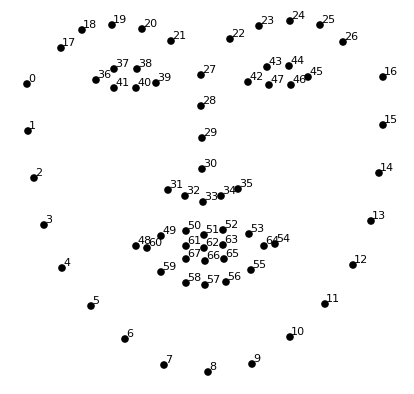

In [ ]:
# find height and width for the arctangent
print(landmark[36][0], landmark[36][1])
print(landmark[45][0], landmark[45][1])
h = landmark[36][1] - landmark[45][1]
w = landmark[45][0] - landmark[36][0]

print ('(h, w) : (%d,%d)'%(h, w))

109 64
164 54
(h, w) : (10,55)


This is the artangent equation i will use to get the angle between the eyes.

In [ ]:
import math
angle = math.atan(h/w)/math.pi*180
print(angle)

10.304846468766033


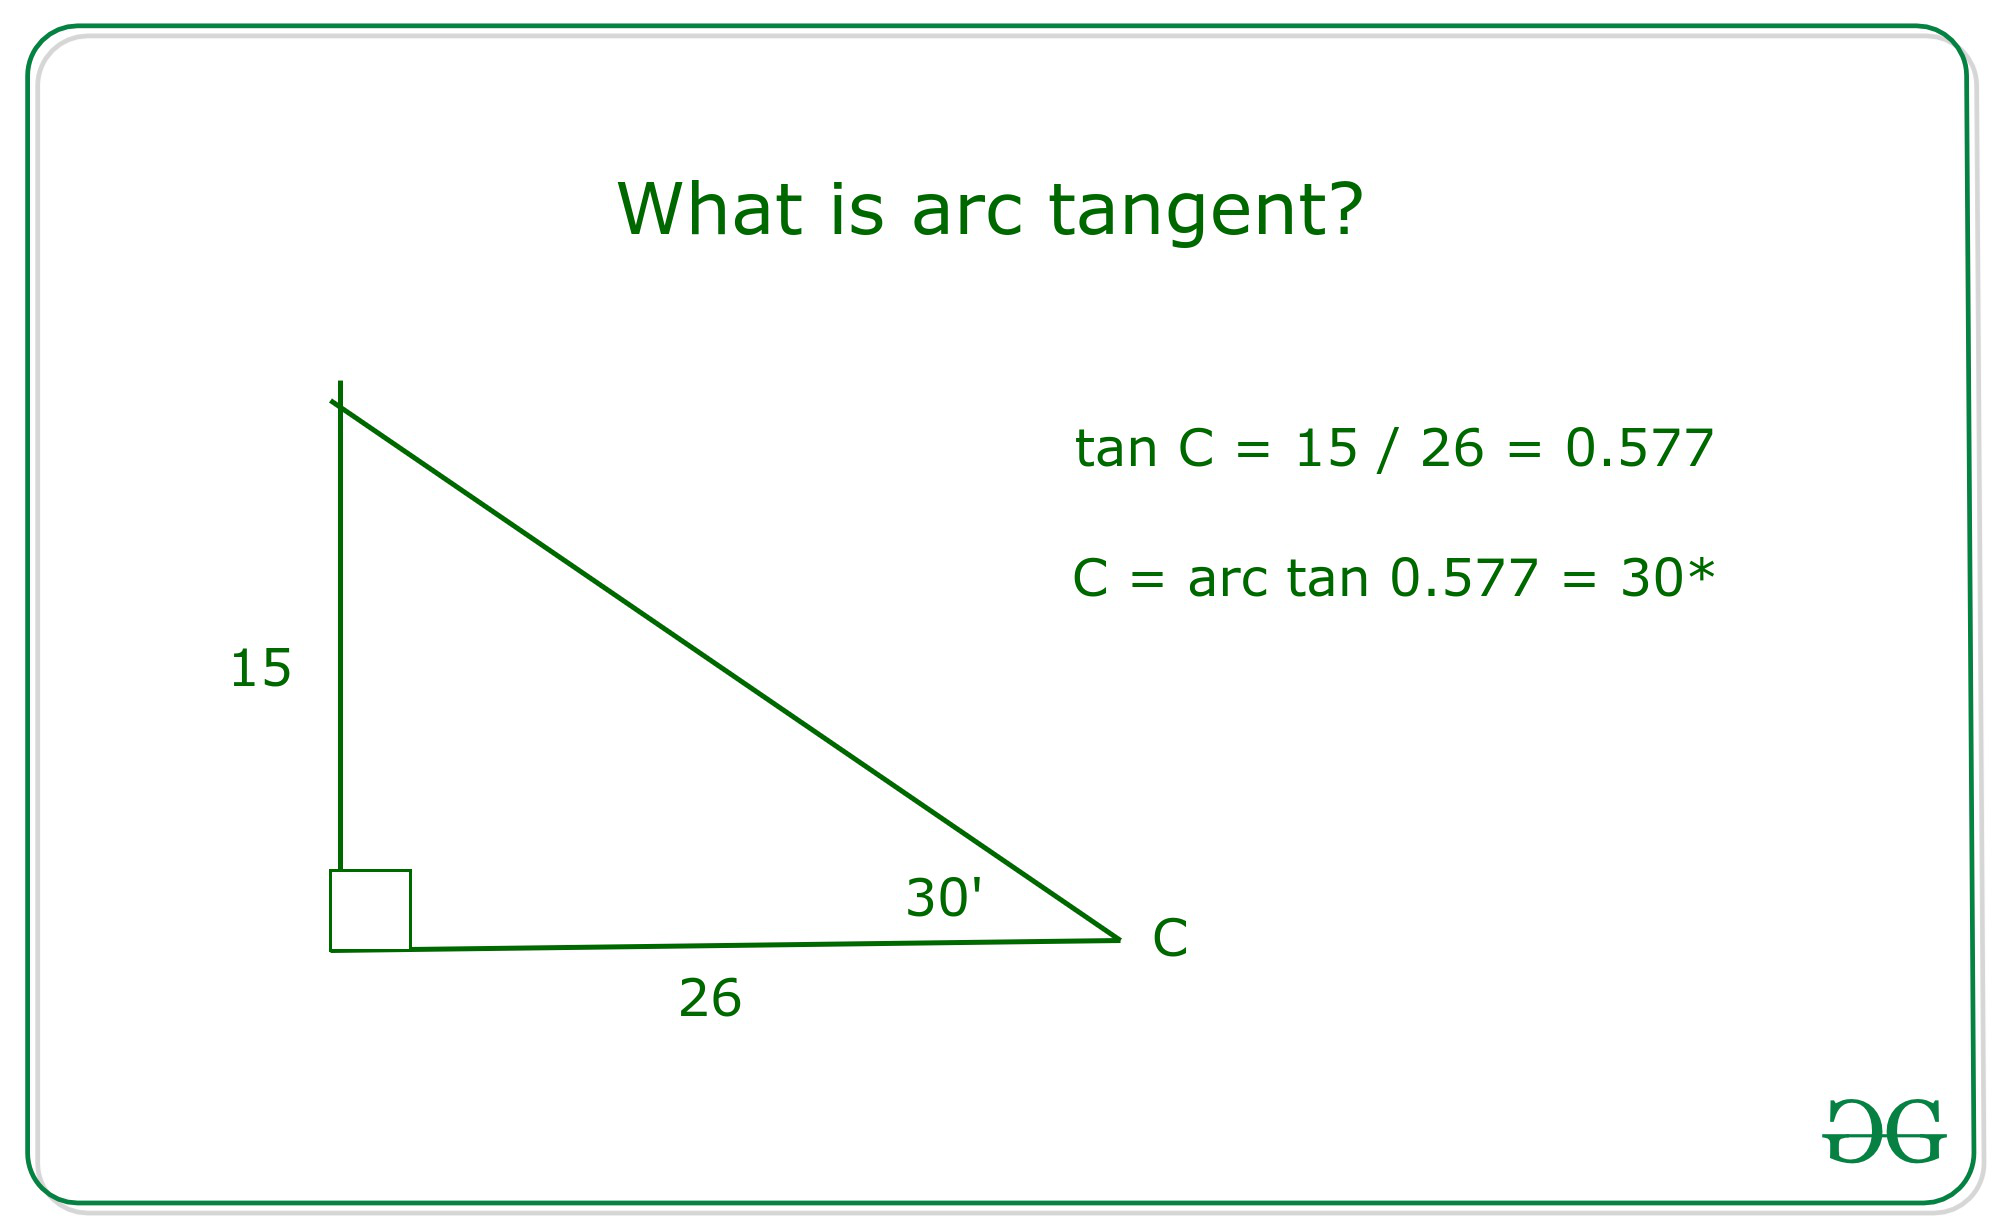

I got the angle, so now I can rotate the whisckers.

In [ ]:
# I will use center parameter as the coordinates of the noes, which is index 33.
rotated_matrix = cv2.getRotationMatrix2D((landmark[33][0], landmark[33][1]), angle, 1)
print(rotated_matrix)

[[  0.98386991   0.17888544 -11.95584193]
 [ -0.17888544   0.98386991  27.40768117]]


Now I got the rotation matrix. Then I can remap the image with `cv.wrapAffine()`.   
Ref: https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html

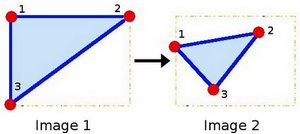

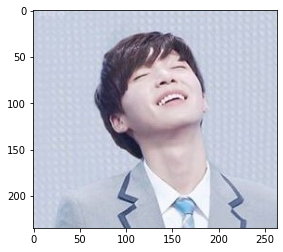

In [ ]:
img_show4 = img_backup.copy()
plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))

plt.show()

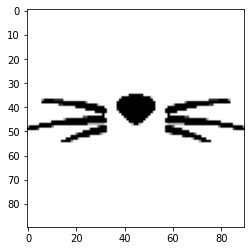

In [ ]:
plt.imshow(side_img_sticker)

In [ ]:
sticker_path = '/content/drive/MyDrive/aiffel/EXP_3_data/whiskers.png'
side_img_sticker = cv2.imread(sticker_path)
w = dlib_rect.width()
h = dlib_rect.width()
side_img_sticker = cv2.resize(side_img_sticker, (w,h))
print (side_img_sticker.shape)

(90, 90, 3)


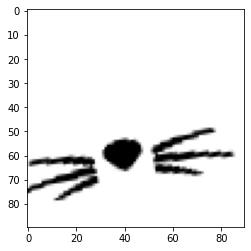

In [ ]:
side_img_sticker_new = cv2.warpAffine(side_img_sticker, rotated_matrix, (side_img_sticker.shape[1], side_img_sticker.shape[0]), borderValue=(255,255,255)
# , borderMode=cv2.BORDER_TRANSPARENT,
)
plt.imshow(side_img_sticker_new)

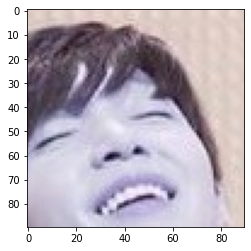

In [ ]:
side_sticker_area = img_show4[refined_y:refined_y+side_img_sticker_new.shape[0], refined_x:refined_x+side_img_sticker_new.shape[1]]
plt.imshow(side_sticker_area)

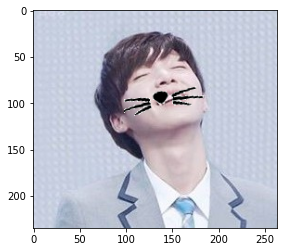

In [ ]:
img_show4[refined_y:refined_y+side_img_sticker_new.shape[0], refined_x:refined_x+side_img_sticker_new.shape[1]] = \
    np.where(side_img_sticker_new==255, side_sticker_area, side_img_sticker_new).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

The med coordinates is a bit off, so I will set x, y coordinates correctly. I will add the some shift values to the sticker's x and y coordinates.

In [ ]:
shift_h = (landmark[36][1] - landmark[45][1]) // 4
shift_w = (landmark[45][0] - landmark[36][0]) // 7

In [ ]:
refined_x = x - w // 2 + shift_w  # left
refined_y = y - h // 2 - 8 * shift_h     # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (105,18)


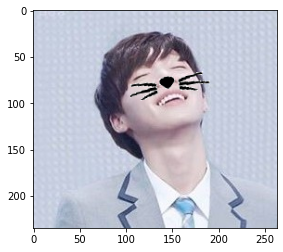

In [ ]:
img_show4[refined_y:refined_y+side_img_sticker_new.shape[0], refined_x:refined_x+side_img_sticker_new.shape[1]] = \
    np.where(side_img_sticker_new==255, side_sticker_area, side_img_sticker_new).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

So satisfying... The whiskers are located at the perfect coordinates!!!     
Everyone please see how cute he is!

# Rotated & Multiple Faces Detection

Lastly, I will try face detection on the rated & multiple faces on an image.

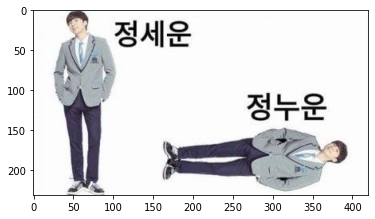

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

my_image_path = '/content/drive/MyDrive/aiffel/EXP_3_data/image12.png';
img_bgr2 = cv2.imread(my_image_path)    # Read image with OpenCV
img_bgr2 = cv2.resize(img_bgr2, (420, 232))    # Resize 
img_show_side_copy = img_bgr2.copy()      # store a copy of the image
plt.imshow(img_bgr2)

img_rgb = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(39, 7) (60, 27)]]


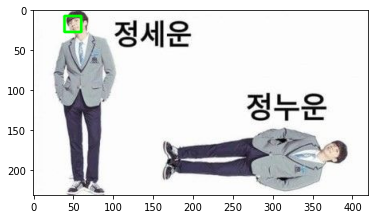

In [2]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   # initialize detector
img_rgb = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 5)   # image, num of img pyramid

print(dlib_rects)   # coordinates of the face found

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_side_copy, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_side_copy_rgb =  cv2.cvtColor(img_show_side_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_side_copy_rgb)
plt.show()

I incremented the number of img pyramid from 1 to 5, then `dlib` was able to detect the face.   
However, unfortunately it was not able to detect the rotated face.

# Conclusion

## Tilted Face Image Detection
Found some useful libraries such as `cv2.getRotationMatrix2D()` which is returning the rotated image matrix based on the angles given, `cv2.getAffineTransform()` which is rotating the image with the same parallel lines.   
Also there is `cv2.getPerspectiveTransform()` which returns the transformed matrix of the perspective.    
They all allow a great image transformation. I want to try them in the future.   

## Rotated, Multiple Faces Image Detection
I was not able to detect face for the rotated image when there are multiple faces in 1 image. For this kind of rotated face, I think If I can detect the fact that the face is rotated, then I can rotate the image using the above `cv2.getRotationMatrix2D()` method then make it possible to detect the face.    
However, still It's too difficult to get the rotated angle automatically.




# References
- rotating and transformation of an image matrix: https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html